## Kickstarter Campaigns Modeling

In [2]:
#data handling/prediction
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn import metrics
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

### Load Data

In [9]:
data = pd.read_csv("data/DSI_kickstarterscrape_dataset.csv", encoding='ISO-8859-1')

#### For data exploration, visit:

https://github.com/iamontheinet/datascience/blob/master/kickstarter_campaigns/notebooks/Kickstarter%20Campaigns%20Analysis.ipynb

### Feature Engineering

In [10]:
clean_data = data.copy()

# Delete samples with missing values
clean_data_nonnull = clean_data.dropna()
print("Fraction of data kept:\n",float(clean_data_nonnull.shape[0])/clean_data.shape[0])
clean_data = clean_data_nonnull

Fraction of data kept:
 0.9700372086950846


In [11]:
# Drop columns we don't need for modeling
del clean_data["project id"]
del clean_data["name"]
del clean_data["url"]
del clean_data["subcategory"]
del clean_data["reward levels"]
del clean_data["funded date"]
del clean_data["pledged"]
del clean_data["backers"]

In [12]:
clean_data.head(20)

,category,location,status,goal,funded percentage,levels,updates,comments,duration
0,Film & Video,"Columbia, MO",successful,10500.0,1.099524,7,10,2,30.00
1,Games,"Maplewood, NJ",failed,4000.0,0.005000,5,6,0,47.18
2,Film & Video,"Los Angeles, CA",live,20000.0,0.002800,10,1,0,28.00
3,Film & Video,"Los Angeles, CA",successful,6000.0,1.089167,13,4,0,32.22
4,Fashion,"Novi, MI",failed,3500.0,0.000000,6,2,0,30.00
5,Film & Video,"Portland, OR",successful,3500.0,1.023331,7,8,0,21.43
6,Film & Video,"Collegedale, TN",failed,1000.0,0.280000,5,0,0,30.00
7,Fashion,"Chicago, IL",successful,2000.0,1.090000,7,13,5,30.00
8,Music,"Chicago, IL",successful,1000.0,1.125000,12,10,1,67.53
9,Art,"Chicago, IL",successful,7500.0,1.311527,10,6,5,35.29


In [13]:
# one-hot code category
category_onehot_coded = clean_data.category.str.get_dummies()
clean_data = clean_data.merge(category_onehot_coded,left_index=True,right_index=True)
del clean_data["category"]

In [14]:
# one-hot code location
popular_locations = clean_data.location.value_counts(ascending=False).head(5)
print("Top 5 locations: ",popular_locations)

def loction_bucket(location):
    if location in popular_locations:
        return location
    
    return "OtherLocation"

clean_data.loc[:,("location")] = clean_data["location"].apply(loction_bucket)
location_onehot_coded = clean_data.location.str.get_dummies()
clean_data = clean_data.merge(location_onehot_coded,left_index=True,right_index=True)
del clean_data["location"]

Top 5 locations:  Los Angeles, CA      3923
New York, NY         3634
Brooklyn, NY         1612
Chicago, IL          1492
San Francisco, CA    1350
Name: location, dtype: int64


In [15]:
# scale goal
clean_goal_data = clean_data.goal.values.reshape(-1, 1)

# Scale clean_data.goal
scaler = StandardScaler() #create a scaler object
scaler.fit_transform(clean_goal_data) #fit the scaler
clean_goal_data_scaled = scaler.transform(clean_goal_data) #transform the data with it

# # compare original to standardized
# print("original values:\n",clean_goal_data[:10],"\n")
# print("scaled values:\n",clean_goal_data_scaled[:10],"\n")

# figure out how the standardization worked
print("Mean of column:\n",scaler.mean_,"\n")
print("standard deviation of column:\n",scaler.scale_,"\n")
print("Final Means of scaled data:\n",clean_goal_data_scaled.mean(axis=0))
print("Final standard deviation of scaled data:\n",clean_goal_data_scaled.std(axis=0))

clean_data.loc[:,("goal")] = clean_goal_data_scaled

print("Goal min value: ",clean_data.goal.min())
print("Goal max value: ",clean_data.goal.max())

Mean of column:
 [12086.52264109] 

standard deviation of column:
 [191613.64464607] 

Final Means of scaled data:
 [-1.91263186e-18]
Final standard deviation of scaled data:
 [1.]
Goal min value:  -0.06307495827564148
Goal max value:  112.01055116404908


In [16]:
# set outcome to 1 = succesful, 0 = everything else
clean_data.loc[:,('outcome')] = (clean_data.status=='successful').astype(int)
del clean_data["status"]
print(clean_data.outcome.value_counts())

1    22322
0    22258
Name: outcome, dtype: int64


In [17]:
clean_data.head(20)

,goal,funded percentage,levels,updates,comments,duration,Art,Comics,Dance,Design,...,Publishing,Technology,Theater,"Brooklyn, NY","Chicago, IL","Los Angeles, CA","New York, NY",OtherLocation,"San Francisco, CA",outcome
0,-0.008280,1.099524,7,10,2,30.00,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,-0.042202,0.005000,5,6,0,47.18,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.041299,0.002800,10,1,0,28.00,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-0.031765,1.089167,13,4,0,32.22,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,-0.044812,0.000000,6,2,0,30.00,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,-0.044812,1.023331,7,8,0,21.43,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
6,-0.057859,0.280000,5,0,0,30.00,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,-0.052640,1.090000,7,13,5,30.00,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
8,-0.057859,1.125000,12,10,1,67.53,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
9,-0.023936,1.311527,10,6,5,35.29,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


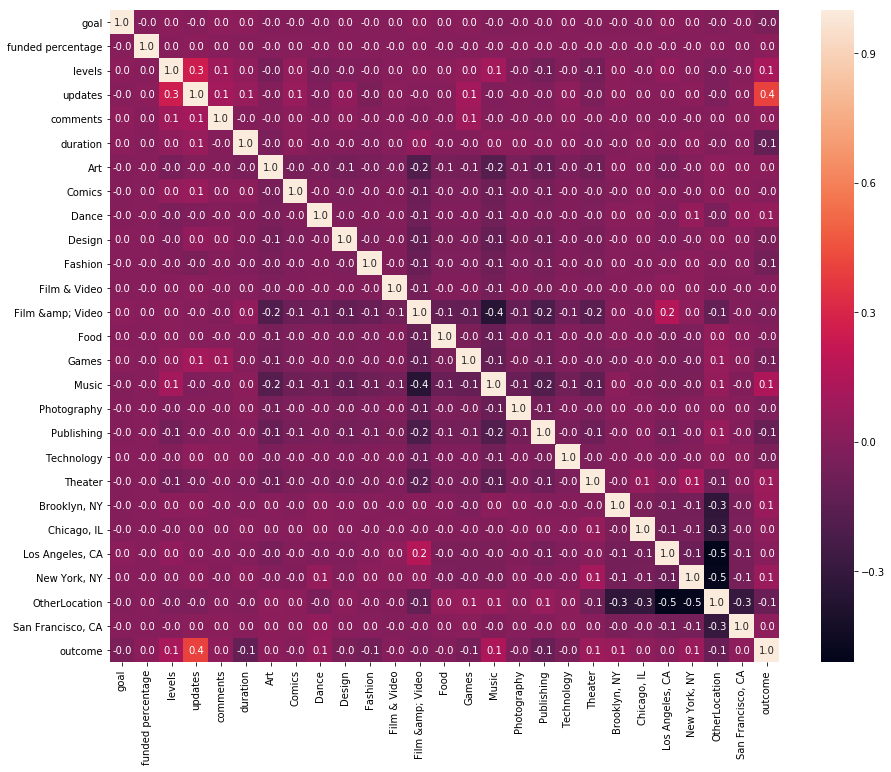

In [18]:
sns.mpl.pyplot.figure(figsize=(15, 12))
sns.heatmap(clean_data.corr(),annot=True, fmt=".1f");

#### Logistic Regression

In [20]:
selected_features = clean_data.columns.tolist()[:-1] # excluding last 'outcome' column

all_features_X = clean_data[selected_features]
all_y = clean_data.outcome

all_X_train,all_X_test,all_y_train,all_y_test = train_test_split(all_features_X,all_y,random_state=42)

logreg_all = LogisticRegression(C=1e9)
logreg_all.fit(all_X_train,all_y_train)

dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(all_X_train, all_y_train)
y_dumb_class = dumb_model.predict(all_X_test)

print("### Data split {0}/{1} with all features ###".format(int((1-n) * 100),int(n * 100)))
print("Bias coefficient (intercept): {0}".format(logreg_all.intercept_[0]))
print("Model accuracy on {0}% training data: {1}".format(int((1-n) * 100),metrics.accuracy_score(all_y_train,logreg_all.predict(all_X_train))))
all_y_test_pred = logreg_all.predict(all_X_test)
print("Model accuracy on {0}% test data: {1}".format(int(n * 100),metrics.accuracy_score(all_y_test,all_y_test_pred)))
print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(all_y_test, y_dumb_class))
print("F1 Score:\n", metrics.f1_score(all_y_test,all_y_test_pred))
print("\r") 
print("Features in order of their absolute coefficient values--indicating their importance")
feature_coeff_df = pd.DataFrame(list(zip(clean_data.columns.tolist()[1:],logreg_all.coef_[0],abs(logreg_all.coef_[0]))),columns=["feature","coefficient","abs_coefficient"])
print(feature_coeff_df.sort_values(['abs_coefficient'],ascending=False))

print("\n")


### Data split 80/20 with all features ###
Bias coefficient (intercept): -4.423888939587225
Model accuracy on 80% training data: 0.982323912068192
Model accuracy on 20% test data: 0.9816958277254374
Most frequent class dummy classifier test accuracy:  0.5013010318528488
F1 Score:
 0.9820675105485233

Features in order of their absolute coefficient values--indicating their importance
              feature  coefficient  abs_coefficient
1              levels     7.085205         7.085205
0   funded percentage    -3.465594         3.465594
14              Music    -1.683090         1.683090
18            Theater    -1.029913         1.029913
9             Fashion    -1.001191         1.001191
7               Dance    -0.989505         0.989505
24  San Francisco, CA    -0.968356         0.968356
25            outcome    -0.915535         0.915535
21    Los Angeles, CA    -0.792702         0.792702
22       New York, NY    -0.774713         0.774713
20        Chicago, IL    -0.501930        

Notes: 
* If bias coefficient (intercept) is positive, knowing nothing else means assume class 1. If negative, assume class 0.
* Positive feature coefficients increase the log-odds of the response being 1 (and thus increase the probability), and negative feature coefficients decrease the log-odds of the response being 1 (and thus decrease the probability).
* In other words, negative feature coefficients forces outcome closer to 0; Positive feature coefficients forces outcome closer to 1.

#### Decision Tree

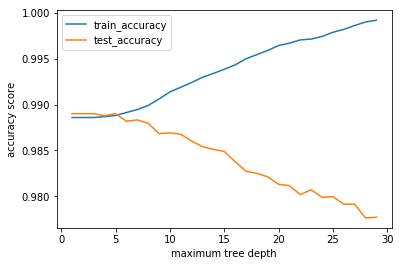

In [21]:
X_train,X_test,y_train,y_test = train_test_split(all_features_X,all_y,test_size=.3,random_state=1)

depths = range(1,30)
train_accuracy, test_accuracy = [],[]
for depth in depths:
    decision_tree = DecisionTreeClassifier(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_accuracy = metrics.accuracy_score(y_train,decision_tree.predict(X_train))
    y_test_pred = decision_tree.predict(X_test)
    curr_test_accuracy = metrics.accuracy_score(y_test,y_test_pred)
    train_accuracy.append(curr_train_accuracy)
    test_accuracy.append(curr_test_accuracy)
#     print("F1 Score:\n", metrics.f1_score(y_test,y_test_pred))
    
sns.mpl.pyplot.plot(depths,train_accuracy,label='train_accuracy')
sns.mpl.pyplot.plot(depths,test_accuracy,label='test_accuracy')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("accuracy score")
sns.mpl.pyplot.legend();

In [22]:
#DecisionTreeClassifier based on the best max_depth observed above
best_single_tree = DecisionTreeClassifier(max_depth=5, random_state=1)
best_single_tree.fit(X_train,y_train)
best_single_tree_y_pred = best_single_tree.predict(X_test)
print("Best Decision Tree Accuracy Score:",metrics.accuracy_score(y_test,best_single_tree_y_pred))

dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y_train)
y_dumb_class = dumb_model.predict(X_test)
print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(y_test, y_dumb_class))
print("F1 Score: ", metrics.f1_score(y_test,best_single_tree_y_pred))

Best Decision Tree Accuracy Score: 0.9890085240017945
Most frequent class dummy classifier test accuracy:  0.49700912217735904
F1 Score:  0.9891903816457093


In [23]:
#Compute the feature importances
feature_imp = pd.DataFrame({'feature':X_train.columns.tolist(), 'importance':best_single_tree.feature_importances_})
print(feature_imp.sort_values("importance",ascending=False)) 

              feature  importance
1   funded percentage    0.997632
4            comments    0.000682
3             updates    0.000613
9              Design    0.000461
2              levels    0.000343
14              Games    0.000140
5            duration    0.000065
7              Comics    0.000043
0                goal    0.000020
20       Brooklyn, NY    0.000000
19            Theater    0.000000
23       New York, NY    0.000000
21        Chicago, IL    0.000000
22    Los Angeles, CA    0.000000
17         Publishing    0.000000
24      OtherLocation    0.000000
18         Technology    0.000000
13               Food    0.000000
16        Photography    0.000000
15              Music    0.000000
12   Film &amp; Video    0.000000
11       Film & Video    0.000000
10            Fashion    0.000000
8               Dance    0.000000
6                 Art    0.000000
25  San Francisco, CA    0.000000


#### Random Forest

In [24]:
rf = RandomForestClassifier(n_estimators=20) #random forest with 20 trees

# Compute cross-validation score accuracy across 10 folds
cross_val_scores = cross_val_score(rf,all_features_X,all_y,cv=10)
print("10-fold accuracies:\n",cross_val_scores)
print("Mean cv-accuracy:",np.mean(cross_val_scores))
print("Std of cv-accuracy:",np.std(cross_val_scores))

10-fold accuracies:
 [0.98587127 0.98833819 0.99080305 0.98900852 0.98900852 0.98855989
 0.98945716 0.98654105 0.98878169 0.98833296]
Mean cv-accuracy: 0.9884702311616668
Std of cv-accuracy: 0.0013271488809076094
